### Importing neccessary libraries

In [238]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score


#### Data Collection and Exploration



Attributes Description :
VARIABLE NAMES: DESCRIPTION

* Encounter ID Unique identifier of an encounter
* Patient number Unique identifier of a patient
* Race Values: Caucasian, Asian, African American, Hispanic, and other
* Gender Values: male, female, and unknown/invalid
* Age Grouped in 10-year intervals: 0, 10), 10, 20), …, 90, 100)
* Weight Weight in pounds
* Admission type Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available
* Discharge disposition Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available
* Admission source Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital
* Time in hospital Integer number of days between admission and discharge
* Payer code Integer identifier corresponding to 23 distinct values, for example, Blue Cross/Blue Shield, Medicare, and self-pay Medical
* Medical specialty Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family/general practice, and surgeon
* Number of lab procedures Number of lab tests performed during the encounter
* Number of procedures Numeric Number of procedures (other than lab tests) performed during the encounter
* Number of medications Number of distinct generic names administered during the encounter
* Number of outpatient visits Number of outpatient visits of the patient in the year preceding the encounter
* Number of emergency visits Number of emergency visits of the patient in the year preceding the encounter
* Number of inpatient visits Number of inpatient visits of the patient in the year preceding the encounter
* Diagnosis 1 The primary diagnosis (coded as first three digits of ICD9); 848 distinct values
* Diagnosis 2 Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values
* Diagnosis 3 Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values
* Number of diagnoses Number of diagnoses entered to the system 0%
* Glucose serum test result Indicates the range of the result or if the test was not taken. Values: “>200,” “>300,” “normal,” and “none” if not measured
* A1c test result Indicates the range of the result or if the test was not taken. Values: “>8” if the result was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none” if not measured.
* Change of medications Indicates if there was a change in diabetic medications (either dosage or generic name). Values: “change” and “no change”
* Diabetes medications Indicates if there was any diabetic medication prescribed. Values: “yes” and “no”
* 24 features for medications For the generic names: metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, glimepiride- pioglitazone, metformin-rosiglitazone, and metformin- pioglitazone, the feature indicates whether the drug was prescribed or there was a change in the dosage. Values: “up” if the dosage was increased during the encounter, “down” if the dosage was decreased, “steady” if the dosage did not change, and “no” if the drug was not prescribed
* Readmitted Days to inpatient readmission. Values: “<30” if the patient was readmitted in less than 30 days, “>30” if the patient was readmitted in more than 30 days, and “No” for no record of readmission

In [239]:
data = pd.read_csv('diabetic_data.csv')
mapping = pd.read_csv('IDS_mapping.csv') # mapping for admission_type_id, discharge_disposition_id, admission_source_id
# we should map data cause numerical values do not reflect any order, 
# a model might infer that admission_type_id = 2 (Urgent) is "closer" to admission_type_id = 3 (Elective) 
# than to admission_type_id = 7 (Trauma Center), which is not meaningful.

In [240]:
# general summary
print(data.shape)  # Rows and columns
print(data.columns)

(101766, 50)
Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


In [241]:
print("Description of Dataset for Categorical Features:")
display(data.describe().T.style.background_gradient(cmap='Blues'))
print("\n")

Description of Dataset for Categorical Features:


,count,mean,std,min,25%,50%,75%,max
encounter_id,101766.000000,165201645.622978,102640295.983458,12522.000000,84961194.000000,152388987.000000,230270887.500000,443867222.000000
patient_nbr,101766.000000,54330400.694947,38696359.346534,135.000000,23413221.000000,45505143.000000,87545949.750000,189502619.000000
admission_type_id,101766.000000,2.024006,1.445403,1.000000,1.000000,1.000000,3.000000,8.000000
discharge_disposition_id,101766.000000,3.715642,5.280166,1.000000,1.000000,1.000000,4.000000,28.000000
admission_source_id,101766.000000,5.754437,4.064081,1.000000,1.000000,7.000000,7.000000,25.000000
time_in_hospital,101766.000000,4.395987,2.985108,1.000000,2.000000,4.000000,6.000000,14.000000
num_lab_procedures,101766.000000,43.095641,19.674362,1.000000,31.000000,44.000000,57.000000,132.000000
num_procedures,101766.000000,1.339730,1.705807,0.000000,0.000000,1.000000,2.000000,6.000000
num_medications,101766.000000,16.021844,8.127566,1.000000,10.000000,15.000000,20.000000,81.000000
number_outpatient,101766.000000,0.369357,1.267265,0.000000,0.000000,0.000000,0.000000,42.000000


In [242]:
print("Description of Dataset for Categorical Features:")
display(data.describe(exclude=np.number).T.style.background_gradient(cmap='Blues'))
print("\n")

Description of Dataset for Categorical Features:


,count,unique,top,freq
race,101766,6,Caucasian,76099
gender,101766,3,Female,54708
age,101766,10,[70-80),26068
weight,101766,10,?,98569
payer_code,101766,18,?,40256
medical_specialty,101766,73,?,49949
diag_1,101766,717,428,6862
diag_2,101766,749,276,6752
diag_3,101766,790,250,11555
max_glu_serum,5346,3,Norm,2597


#### Handling missing values

Features that contain missing values according to documentation


In [243]:
# dropping features which has more than 85% of missing values or has only one value, payer code is not relevant to output
data = data.drop(columns= ['max_glu_serum','A1Cresult','weight','citoglipton','examide','payer_code'])
print(data.shape)

(101766, 44)


In [244]:
# Handling missing data
data['race'] = data['race'].replace('?', 'unknown') # we can not assume what is the race
data['medical_specialty'] = data['medical_specialty'].replace('?', 'unknown')




In [245]:
# remove 3 records of unknown gender
print(data['gender'].value_counts())
data.drop(data[data['gender'] == 'Unknown/Invalid'].index, inplace=True)
print(data.shape)

gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: count, dtype: int64
(101763, 44)


In [246]:
# Check for '?' or NaN and remove rows 
l = ['diag_1','diag_2','diag_3']
for col in l:
    count_invalid = ((data[col] == '?') | (data[col].isna())).sum()
    print(f"Number of invalid values ('?' or NaN): {count_invalid}")
index=[]
index=list(data[data['diag_1']=='?'].index)
index.extend(data[data['diag_2']=='?'].index)
index.extend(data[data['diag_3']=='?'].index)
data.drop(index=index,inplace=True)
print(data.shape)

Number of invalid values ('?' or NaN): 21
Number of invalid values ('?' or NaN): 358
Number of invalid values ('?' or NaN): 1423
(100241, 44)


#### Feature Engineering

In [247]:
from sklearn.preprocessing import LabelEncoder

# Label encode the age ranges 
encoder = LabelEncoder()
data['age'] = encoder.fit_transform(data['age']) + 1


 In order to reduce dimensionality of features **admission_type_id**, **discharge_disposition_id**, **admission_source_id** we investigate the mapping with the description given to every value. Following values can be treated as equal:

admission_type_id:
* Unavailable values: 5, 6, 8

discharge_disposition_id:
* Unavailable values: 18, 25, 26
* discharged to home: 1, 6, 8 
* discharged to hospital: 2, 9, 10, 23, 27, 28, 29
* Expired: 11, 19, 20, 21
* Hospice: 13, 14
* Discharged/Transferred to Care Facility: 3, 4, 5, 15, 24
* Discharged to Outpatient Services: 16, 17


admission_source_id:
* Unavailable values: 9, 15, 17, 20, 21
* Physician/Clinic Referral: 1, 2, 3
* Transfer from Hospital: 4, 10, 22
* Transfer from Facility: 5, 6, 18, 19, 25, 26
* Delivery: 11, 12, 13, 14


In [248]:
# we need to investigate mapping and reduce dimensionality
# in admission_type_id 5, 6, 8 are not available or not mapped
data['admission_type_id']=data['admission_type_id'].apply(lambda x : 5 if x in (6,8) else x)
# discharge_disposition_id 
data['discharge_disposition_id']=data['discharge_disposition_id'].apply(lambda x : 18 if x in (25,26) else x)
data['discharge_disposition_id']=data['discharge_disposition_id'].apply(lambda x : 1 if x in (6,8) else x)
data['discharge_disposition_id']=data['discharge_disposition_id'].apply(lambda x : 2 if x in (9,10,23,27,28,29) else x)
data['discharge_disposition_id']=data['discharge_disposition_id'].apply(lambda x : 11 if x in (19,20,21) else x)
data['discharge_disposition_id']=data['discharge_disposition_id'].apply(lambda x : 13 if x ==14 else x)
data['discharge_disposition_id']=data['discharge_disposition_id'].apply(lambda x : 3 if x in (4,5,15,24) else x)
data['discharge_disposition_id']=data['discharge_disposition_id'].apply(lambda x : 16 if x ==17 else x)

# admission_source_id 
data['admission_source_id']=data['admission_source_id'].apply(lambda x : 9 if x in (15,17,20,21) else x)
data['admission_source_id']=data['admission_source_id'].apply(lambda x : 1 if x in (2,3) else x)
data['admission_source_id']=data['admission_source_id'].apply(lambda x : 4 if x in (10,22) else x)
data['admission_source_id']=data['admission_source_id'].apply(lambda x : 5 if x in (6,18,19,25,26) else x)
data['admission_source_id']=data['admission_source_id'].apply(lambda x : 11 if x in (12,13,14) else x)



In [249]:

print(len(data['admission_type_id'].unique()))
print(len(data['discharge_disposition_id'].unique()))
print(len(data['admission_source_id'].unique()))

6
10
7


diag_1, diag_2, diag_3 are coded as 3 digits from ICD-9 list:
* List of ICD-9 codes 001–139: infectious and parasitic diseases
* List of ICD-9 codes 140–239: neoplasms
* List of ICD-9 codes 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
* List of ICD-9 codes 280–289: diseases of the blood and blood-forming organs
* List of ICD-9 codes 290–319: mental disorders
* List of ICD-9 codes 320–389: diseases of the nervous system and sense organs
* List of ICD-9 codes 390–459: diseases of the circulatory system
* List of ICD-9 codes 460–519: diseases of the respiratory system
* List of ICD-9 codes 520–579: diseases of the digestive system
* List of ICD-9 codes 580–629: diseases of the genitourinary system
* List of ICD-9 codes 630–679: complications of pregnancy, childbirth, and the puerperium
* List of ICD-9 codes 680–709: diseases of the skin and subcutaneous tissue
* List of ICD-9 codes 710–739: diseases of the musculoskeletal system and connective tissue
* List of ICD-9 codes 740–759: congenital anomalies
* List of ICD-9 codes 760–779: certain conditions originating in the perinatal period
* List of ICD-9 codes 780–799: symptoms, signs, and ill-defined conditions
* List of ICD-9 codes 800–999: injury and poisoning
* List of ICD-9 codes E and V codes: external causes of injury and supplemental classification

In [250]:
# Define ICD-9 code ranges and corresponding clusters
icd9_clusters = {
    range(1, 140): 1,   # 001–139: infectious and parasitic diseases
    range(140, 240): 2, # 140–239: neoplasms
    range(240, 280): 3, # 240–279: endocrine, nutritional, metabolic
    range(280, 290): 4, # 280–289: blood diseases
    range(290, 320): 5, # 290–319: mental disorders
    range(320, 390): 6, # 320–389: nervous system diseases
    range(390, 460): 7, # 390–459: circulatory system diseases
    range(460, 520): 8, # 460–519: respiratory diseases
    range(520, 580): 9, # 520–579: digestive diseases
    range(580, 630): 10, # 580–629: genitourinary diseases
    range(630, 680): 11, # 630–679: pregnancy complications
    range(680, 710): 12, # 680–709: skin diseases
    range(710, 740): 13, # 710–739: musculoskeletal diseases
    range(740, 760): 14, # 740–759: congenital anomalies
    range(760, 780): 15, # 760–779: perinatal conditions
    range(780, 800): 16, # 780–799: ill-defined conditions
    range(800, 1000): 17, # 800–999: injury and poisoning
    'E': 18, 'V': 18      # E and V codes: external causes
}


In [251]:
def assign_cluster(code):
    try:
        # Check if the code starts with 'E' or 'V'
        if isinstance(code, str) and (code.startswith('E') or code.startswith('V')):
            return 18
        # Convert to numeric if it's a number
        code_numeric = int(float(code))
        for code_range, cluster in icd9_clusters.items():
            if isinstance(code_range, range) and code_numeric in code_range:
                return cluster
    except (ValueError, TypeError):  # Handle invalid entries
        return None  # Return None for invalid codes
    return None  # Default case


In [252]:
# Apply the assign_cluster function to each diagnosis column
data['diag_1'] = data['diag_1'].apply(assign_cluster)
data['diag_2'] = data['diag_2'].apply(assign_cluster)
data['diag_3'] = data['diag_3'].apply(assign_cluster)


In [253]:
print(data['diag_1'].unique())
print(data['diag_2'].unique())
print(data['diag_3'].unique())

[ 3 11  1  2  7  8 17 12 13  9 18 16 10  5  6  4 14]
[ 3  2  7  8  4 17 13 10  1  9 12 18  6 16  5 11 14]
[ 3 18  7  1  8 17  2 10 13 16  9 12  5 14  6 11  4]


In [254]:
data.columns


Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

#### Encoding categorical features

In [255]:
data['gender']=data['gender'].apply(lambda x: 0 if x=='Female' else 1)


In [256]:
# any other change will be indicated as 1, and no change as 0 (medical features had values of up, down, steady and no)
medical_f = ['metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']
for col in medical_f:
    data[col] = data[col].apply(lambda x: 0 if x == 'No' else 1)

In [257]:
data['change']=data['change'].apply(lambda x : 0 if x=='No' else 1)
data['change'].unique()

array([1, 0])

In [258]:
data['diabetesMed']=data['diabetesMed'].apply(lambda x : 0 if x=='No' else 1)
data['diabetesMed'].unique()

array([1, 0])

In [259]:
# target feature
# as we want to predict readmission in first 30 days
data['readmitted']=data['readmitted'].apply(lambda x : 1 if x=='<30' else 0)
data['readmitted'].unique()


array([0, 1])

In [260]:
# drop unnecessary columns 'encounter_id', 'patient_nbr' and 'medical specialty'is just too high dimensional 
data = data.drop(columns= ['encounter_id', 'patient_nbr','medical_specialty'])
other = ['race', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses']


In [261]:
other = ['race', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses']
data[other].describe().T

,count,mean,std,min,25%,50%,75%,max
age,100241.0,7.127652,1.558504,1.0,6.0,7.0,8.0,10.0
admission_type_id,100241.0,1.961473,1.280210,1.0,1.0,1.0,3.0,7.0
discharge_disposition_id,100241.0,2.837352,4.720988,1.0,1.0,1.0,3.0,22.0
admission_source_id,100241.0,5.170639,2.866998,1.0,1.0,7.0,7.0,11.0
time_in_hospital,100241.0,4.420307,2.991258,1.0,2.0,4.0,6.0,14.0
num_lab_procedures,100241.0,43.173991,19.691339,1.0,32.0,44.0,57.0,132.0
num_procedures,100241.0,1.350236,1.710899,0.0,0.0,1.0,2.0,6.0
num_medications,100241.0,16.117816,8.116446,1.0,11.0,15.0,20.0,81.0
number_outpatient,100241.0,0.372572,1.274092,0.0,0.0,0.0,0.0,42.0
number_emergency,100241.0,0.199020,0.933554,0.0,0.0,0.0,0.0,76.0


In [262]:
data[other].describe(exclude=np.number).T

,count,unique,top,freq
race,100241,6,Caucasian,75079


In [263]:
data['diag_1']

1          3
2         11
3          1
4          2
5          7
          ..
101761     3
101762     9
101763     1
101764    17
101765     9
Name: diag_1, Length: 100241, dtype: int64

In [264]:
# need to understand what to do with 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3'
data = pd.get_dummies(data, columns=['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
# # One-hot encode the clusters
data = pd.get_dummies(data, columns=['diag_1', 'diag_2', 'diag_3'], prefix=['diag1', 'diag2', 'diag3'])
# encode race
data = pd.get_dummies(data, columns=['race'])

In [265]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,100241.0,0.462076,0.498562,0.0,0.0,0.0,1.0,1.0
age,100241.0,7.127652,1.558504,1.0,6.0,7.0,8.0,10.0
time_in_hospital,100241.0,4.420307,2.991258,1.0,2.0,4.0,6.0,14.0
num_lab_procedures,100241.0,43.173991,19.691339,1.0,32.0,44.0,57.0,132.0
num_procedures,100241.0,1.350236,1.710899,0.0,0.0,1.0,2.0,6.0
num_medications,100241.0,16.117816,8.116446,1.0,11.0,15.0,20.0,81.0
number_outpatient,100241.0,0.372572,1.274092,0.0,0.0,0.0,0.0,42.0
number_emergency,100241.0,0.199020,0.933554,0.0,0.0,0.0,0.0,76.0
number_inpatient,100241.0,0.639489,1.262787,0.0,0.0,0.0,1.0,21.0
number_diagnoses,100241.0,7.497052,1.839509,3.0,6.0,8.0,9.0,16.0


#### Standardize and balance data

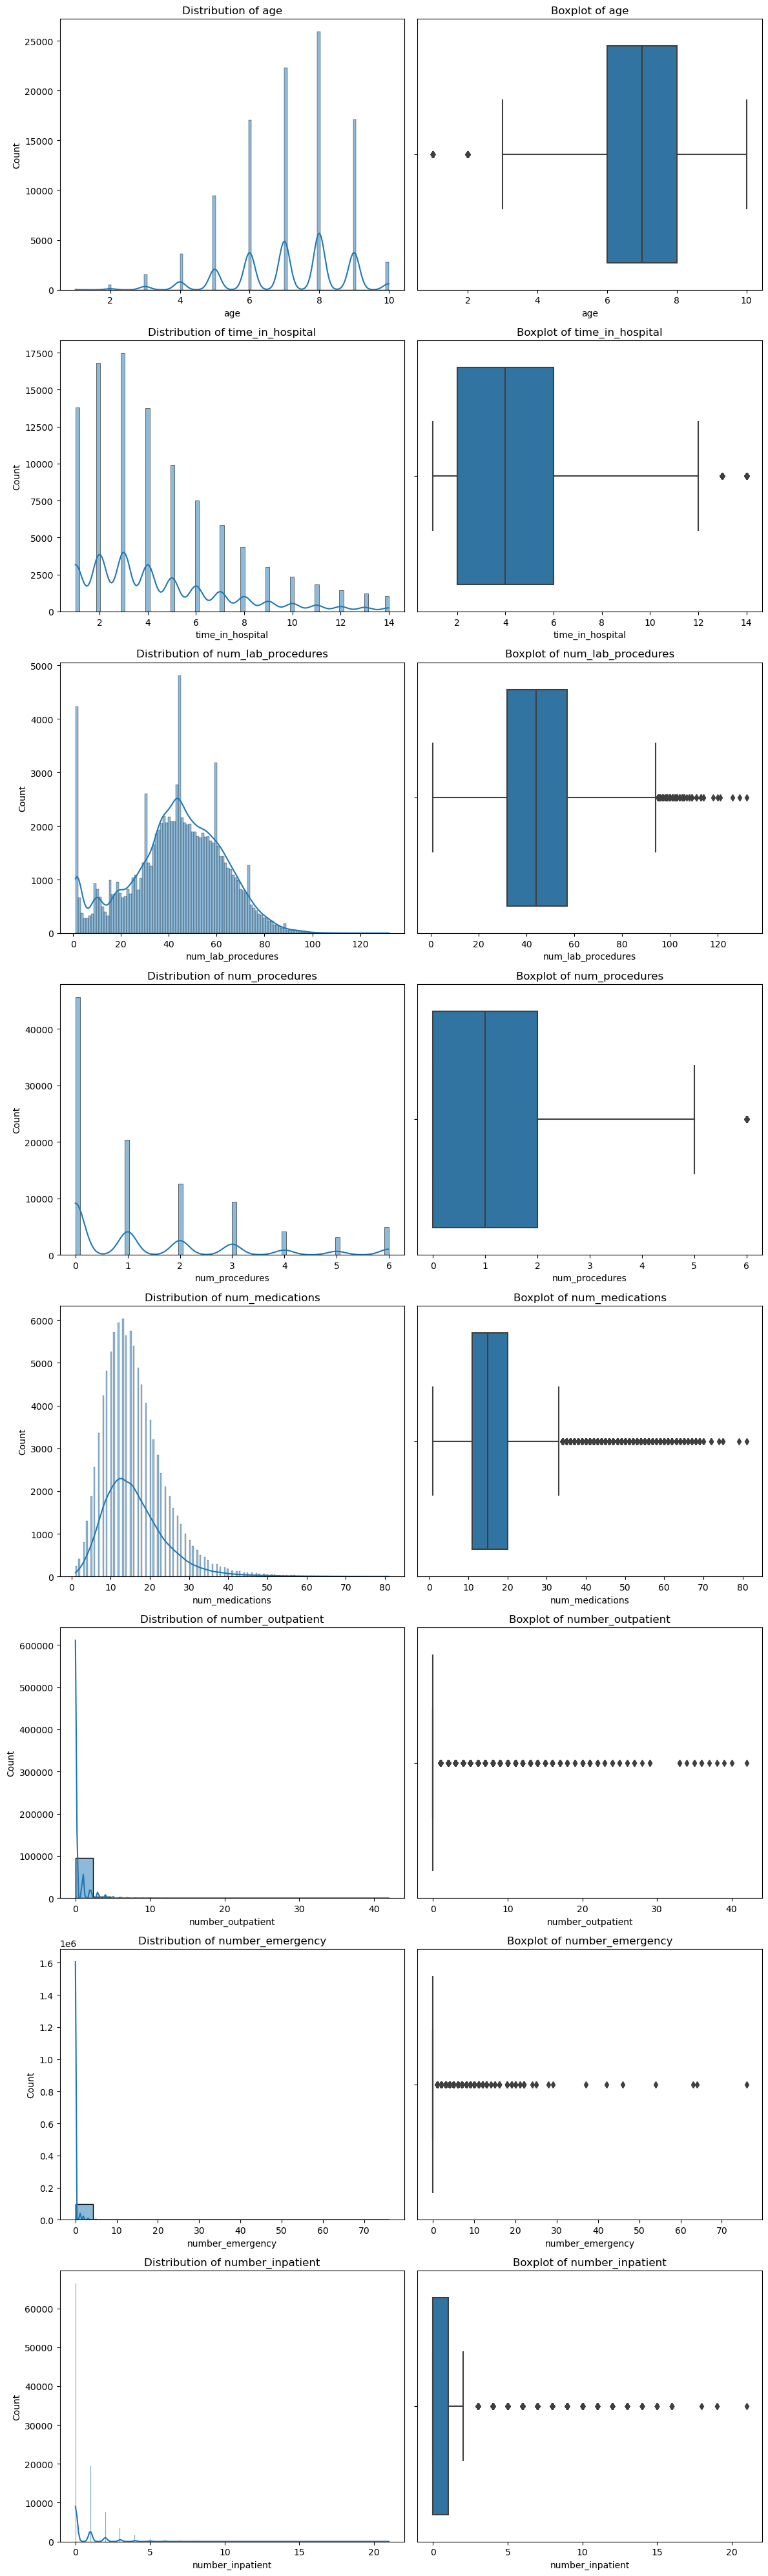

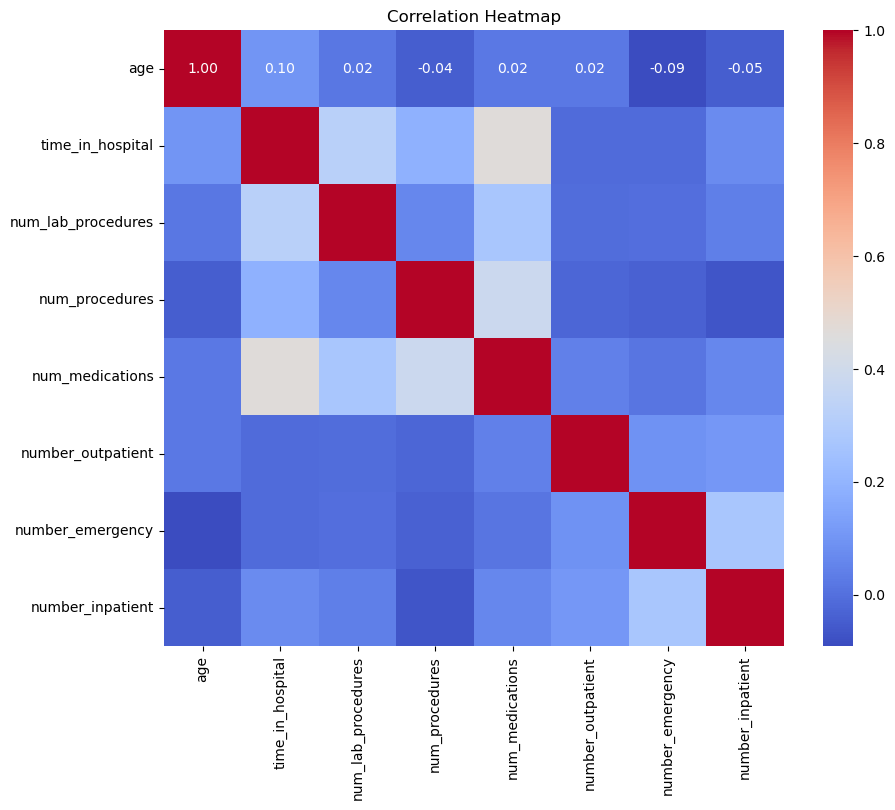

In [266]:
def analyze_numerical_columns(data, num_columns):
    """
    Analyzes numerical columns in a DataFrame by plotting distributions, boxplots,
    and a correlation heatmap.
    
    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        num_columns (list): List of numerical column names to analyze.
    """
    # Check if the specified columns exist in the DataFrame
    missing_cols = [col for col in num_columns if col not in data.columns]
    if missing_cols:
        print(f"Warning: These columns are not in the DataFrame: {missing_cols}")
        num_columns = [col for col in num_columns if col in data.columns]
    
    if not num_columns:
        print("No valid numerical columns provided.")
        return
    
    # Set up subplots
    num_cols = len(num_columns)
    fig, axes = plt.subplots(num_cols, 2, figsize=(12, num_cols * 5))
    
    for i, col in enumerate(num_columns):
        # Distribution plot
        sns.histplot(data[col], kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f'Distribution of {col}')
        axes[i, 0].set_xlabel(col)
        
        # Boxplot
        sns.boxplot(x=data[col], ax=axes[i, 1])
        axes[i, 1].set_title(f'Boxplot of {col}')
        axes[i, 1].set_xlabel(col)
    
    plt.tight_layout()
    plt.show()
    
    # Correlation heatmap
    correlation_matrix = data[num_columns].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.show()


num_columns = ['age',
       'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient']
# Assuming you have a DataFrame `data`
analyze_numerical_columns(data, num_columns)


In [276]:
def remove_outliers_iqr_multiple_columns(data, columns):
    """
    Removes outliers from multiple columns in a DataFrame based on the IQR method.

    """
    data_cleaned = data.copy()
    for column in columns:
        if column in data_cleaned.columns:
            Q1 = data_cleaned[column].quantile(0.25)
            Q3 = data_cleaned[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            data_cleaned = data_cleaned[
                (data_cleaned[column] >= lower_bound) & (data_cleaned[column] <= upper_bound)
            ]
        else:
            print(f"Warning: Column '{column}' not found in DataFrame.")
    return data_cleaned

# Example usage
num_columns_outliers = ['age',
       'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications']


data_cleaned = remove_outliers_iqr_multiple_columns(data, num_columns_outliers)


In [277]:
data_cleaned.shape

(91328, 114)

In [269]:
data.shape

(100241, 114)

In [285]:
# we will do log transformation to too much skewed data
data['number_outpatient_log'] = np.log1p(data['number_outpatient'])  # log(1 + x) to handle zero values
data['number_emergency_log'] = np.log1p(data['number_emergency'])
data['number_inpatient_log'] = np.log1p(data['number_inpatient'])




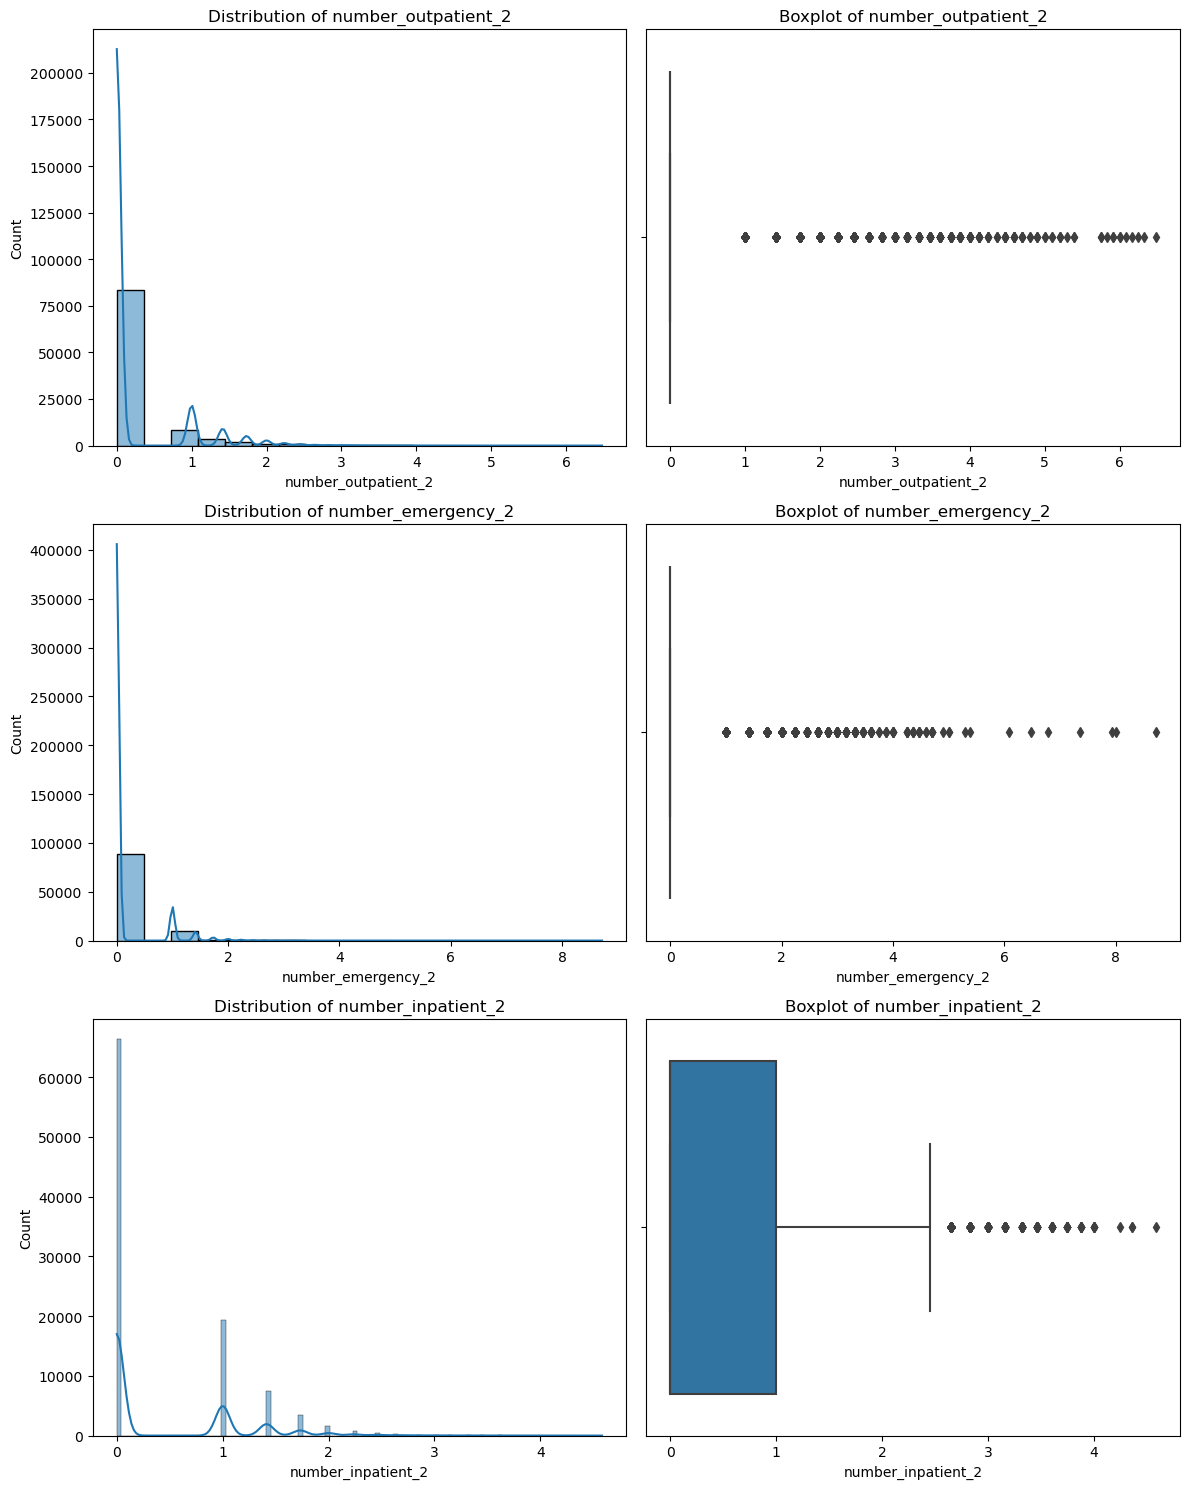

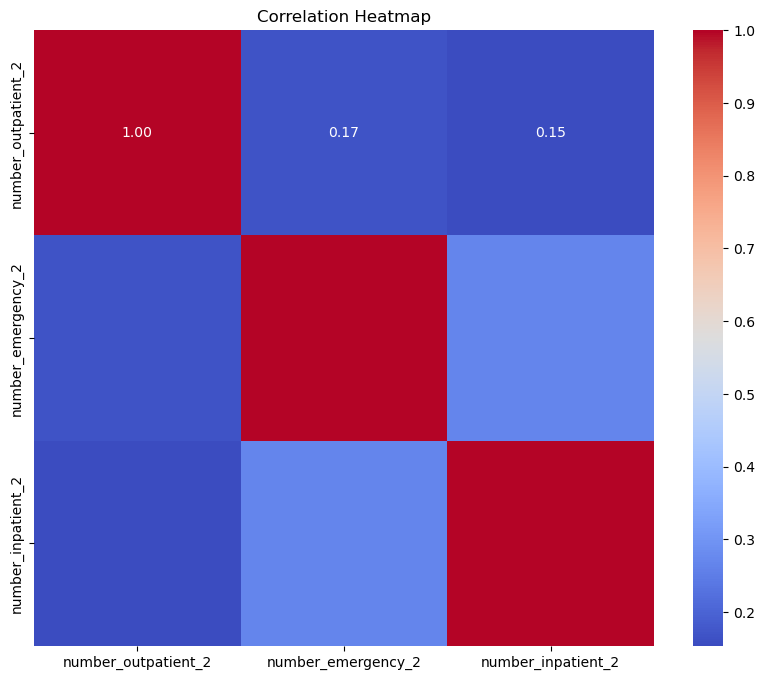

In [286]:
log_trans_columns = ['number_outpatient_log', 'number_emergency_log','number_inpatient_log']
analyze_numerical_columns(data, log_trans_columns)